# Práctica 3

## Importación de Librerías

In [1]:
# Librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score

# Configuración de visualización
pd.set_option("display.max_columns", 30)
plt.style.use('ggplot')
sns.set_palette("magma")

## Carga y Exploración de Datos

In [2]:
# Lectura de Datos
df = pd.read_csv("datasets/titanic.csv")

print("Forma inicial del dataset:", df.shape)
print("\nDistribución de supervivencia:")
print(df['survived'].value_counts(normalize=True))

print("\nValores faltantes:")
print(df.isnull().mean().sort_values(ascending=False).head(10))

Forma inicial del dataset: (1310, 14)

Distribución de supervivencia:
survived
0.0    0.618029
1.0    0.381971
Name: proportion, dtype: float64

Valores faltantes:
body         0.907634
cabin        0.774809
boat         0.629008
home.dest    0.431298
age          0.201527
embarked     0.002290
fare         0.001527
pclass       0.000763
survived     0.000763
name         0.000763
dtype: float64


## Limpieza de Datos

In [3]:
# Eliminamos filas con valores faltantes en variables críticas
df = df[(~df["survived"].isnull()) & 
        (~df["pclass"].isnull()) & 
        (~df["fare"].isnull())].copy()

print("\nForma después de la limpieza:", df.shape)



Forma después de la limpieza: (1308, 14)


## Ingeniería de Características

In [4]:
def enhanced_feature_engineering(df):

    # Características familiares
    # Tamaño del grupo familiar (hermanos/esposos + padres/hijos + el pasajero)
    df['family_size'] = df['sibsp'] + df['parch'] + 1
    # Indicador de si viaja solo (1) o con familia (0)
    df['is_alone'] = (df['family_size'] == 1).astype(int)
    
    # Extracción de títulos desde el nombre
    df['title'] = df['name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
    # Consolidación de títulos raros en una sola categoría
    df['title'] = df['title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',
                                     'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    # Unificación de títulos equivalentes
    df['title'] = df['title'].replace(['Mlle', 'Ms'], 'Miss').replace('Mme', 'Mrs')
    
    # Conversión de variables categóricas a numéricas
    df['sex'] = df['sex'].map({'female': 0, 'male': 1}).astype(int)
    # Mapeo de puertos de embarque (S=0, C=1, Q=2) con imputación de valores faltantes
    df['embarked'] = df['embarked'].fillna('S').map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    
    # Procesamiento de edad:
    # Imputación de valores faltantes con la mediana por título y clase
    df['age'] = df.groupby(['title', 'pclass'])['age'].transform(lambda x: x.fillna(x.median()))
    # Discretización de edad en rangos (0-12, 13-20, 21-40, 41-60, 61-100)
    df['age_bin'] = pd.cut(df['age'], bins=[0, 12, 20, 40, 60, 100], labels=False)
    
    # Características mejoradas de tarifa:
    # Tarifa por persona (considerando el tamaño familiar)
    df['fare_per_person'] = df['fare'] / (df['family_size'] + 0.001)  # +0.001 para evitar división por 0
    # Discretización de tarifa en quintiles
    df['fare_bin'] = pd.qcut(df['fare'], 5, labels=False, duplicates='drop')
    
    # Características de cabina:
    # Indicador de si tiene cabina asignada (1) o no (0)
    df['has_cabin'] = df['cabin'].notnull().astype(int)
    
    # Características de interacción:
    # Interacción entre edad y clase
    df['age_class'] = df['age'] * df['pclass']
    # Interacción entre tarifa y clase
    df['fare_class'] = df['fare'] * df['pclass']
    
    # Eliminación de columnas no relevantes para el modelo
    return df.drop(['name', 'ticket', 'cabin', 'boat', 'body', 'home.dest'], 
                  axis=1, errors='ignore')

df = enhanced_feature_engineering(df)

## Preparación de Datos para Modelado

In [5]:
# Definimos características y variable objetivo

numerical_features = [col for col in df.columns 
                     if col not in ['survived'] and df[col].dtype in ['int64', 'float64']]
X = df[numerical_features]
y = df['survived'].astype(int)

# División en conjuntos de entrenamiento y validación
Xt, Xv, yt, yv = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print(f"\nForma final de la matriz de características: {Xt.shape}")
print("Características utilizadas:", numerical_features)



Forma final de la matriz de características: (915, 15)
Características utilizadas: ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'family_size', 'is_alone', 'age_bin', 'fare_per_person', 'fare_bin', 'has_cabin', 'age_class', 'fare_class']


## Configuración y Entrenamiento de Random Forest

In [6]:
'''
**Estrategia de entrenamiento:**
1. Usamos GridSearchCV para optimizar hiperparámetros (evitando overfitting).
2. La métrica de evaluación es AUC-ROC (ideal para problemas con clases desbalanceadas).
3. Validación cruzada (5 folds) para asegurar generalización.
'''

# Definimos el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [300, 400, 500],  # Número de árboles (usamos valores altos para robustez)
    'max_depth': [5, 6, 7],           # Controla complejidad (evita overfitting)
    'min_samples_split': [5, 10, 15], # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [2, 3, 4],    # Mínimo de muestras en nodos hoja
    'max_features': [0.6, 0.8, 'sqrt'], # Características consideradas por árbol
    'bootstrap': [True],              # Muestreo con reemplazo (bagging)
    'class_weight': ['balanced', None] # Manejo del desbalanceo de clases
}

# Inicializamos el modelo base de Random Forest
rf_model = RandomForestClassifier(
    random_state=42,  # Semilla para reproducibilidad
    n_jobs=-1         # Paralelización
)

# Configuramos la búsqueda en grid con validación cruzada
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,               # 5-fold cross-validation
    scoring='roc_auc',   # Métrica a optimizar
    n_jobs=-1,          # Paralelización
    verbose=1           # Mostrar progreso
)

# Entrenamos el modelo
print("\nEntrenando Random Forest con GridSearchCV...")
grid_search.fit(Xt, yt)

# Obtenemos el mejor modelo después de la búsqueda
best_rf = grid_search.best_estimator_
print("\nEntrenamiento completo!")


Entrenando Random Forest con GridSearchCV...
Fitting 5 folds for each of 486 candidates, totalling 2430 fits

Entrenamiento completo!


## Evaluación del Modelo


=== RENDIMIENTO DEL MODELO ===
Mejores parámetros: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 400}
AUC en train: 0.9103
AUC en validate: 0.8951

Top 10 características más importantes:
            Feature  Importance
1               sex    0.327534
13        age_class    0.116911
10  fare_per_person    0.084272
14       fare_class    0.082666
5              fare    0.079738
2               age    0.063610
7       family_size    0.043487
0            pclass    0.038170
12        has_cabin    0.035169
3             sibsp    0.029714


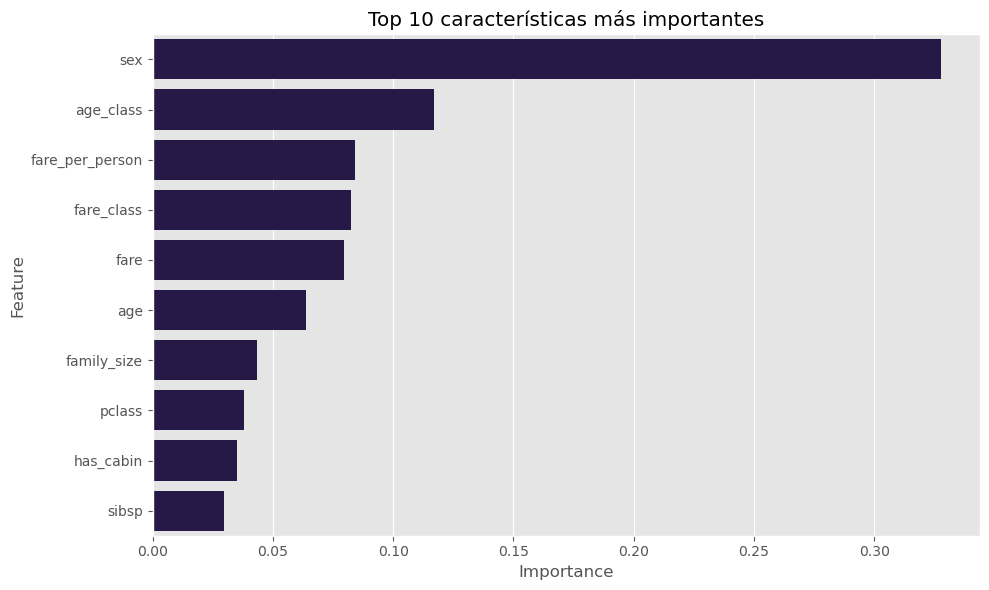

In [7]:
# Calculamos probabilidades para evaluación
train_probs = best_rf.predict_proba(Xt)[:,1]
val_probs = best_rf.predict_proba(Xv)[:,1]

# Mostramos resultados
print("\n=== RENDIMIENTO DEL MODELO ===")
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"AUC en train: {roc_auc_score(yt, train_probs):.4f}")
print(f"AUC en validate: {roc_auc_score(yv, val_probs):.4f}")

# =============================================
# ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS
# =============================================
# Creamos dataframe con las importancias
importance = pd.DataFrame({
    'Feature': Xt.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 características más importantes:")
print(importance.head(10))

# Visualizamos las características más importantes
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance.head(10))
plt.title('Top 10 características más importantes')
plt.tight_layout()
plt.show()

## Conclusiones 

In [8]:
# Para este modelo se mejoró la limpieza de datos imputando valores en lugar de eliminar filas. 
# También se hizo una mejor ingeniería que incorpora interacciones como age_class y fare_per_person.
# La optimización con GridSearchCV asegura hiperparámetros que evitan overfitting.
# El análisis de importancia nos dice que las nuevas variables son predictivas (como sex que aporta el 32.7%).